In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import ROOT
from ROOT import TH1F, TF1, TCanvas
import uproot
import iminuit
import probfit
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
def smooth(x, window_len=11, window="hanning"):
    # if x.ndim != 1:
    #     raise ValueError("smooth only accepts 1 dimension arrays.")

    # if x.size < window_len:
    #     raise ValueError("Input vector needs to be bigger than window size.")

    # if window_len < 3:
    #     return x

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    # print(len(s))
    if window == "flat":  # moving average
        w = np.ones(window_len)
    else:
        w = eval("np." + window + "(window_len)")

    y = signal.convolve(s, w / w.sum(), mode="same")

    return y

In [3]:
!ls

muon_decay-Copy1.ipynb	root_converter.ipynb
muon_decay.ipynb	single_analysis_test.ipynb


In [4]:
# rel_path = "./Labs/muon_decay/"
# filename = rel_path + "oscil_191216.root"
rel_path = "../../Labs/muon_decay/"
filename = rel_path + "mudecays824.root"

In [5]:
# df = RDataFrame("tree",filename)

In [6]:
# df_np = RDataFrame("tree",filename).AsNumpy()
# df_np["channel1"].size

In [7]:
# raw_data = df_np["channel1"][1169]
# n_per_event = raw_data.size()
# timesteps = np.arange(0,n_per_event,1)
# raw_data *= -1.0

In [8]:
df_np = uproot.open(filename)["t1"].array("channel1")
n_events = df_np.size
n_per_event = df_np[0].size
timesteps = np.arange(0,n_per_event,1)


In [9]:
# raw_data = np.negative(df_np[236])
raw_data = np.negative(df_np[4])

In [10]:
smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
data = np.concatenate((timesteps[:,np.newaxis], smoothed_data[:n_per_event ,np.newaxis]), axis=1)
peak_range = [0.2, data[: ,1].max() ]
peaks, properties = signal.find_peaks(data[: ,1], height=peak_range,distance=200)
results_w = signal.peak_widths(data[: ,1], peaks, rel_height=0.95)


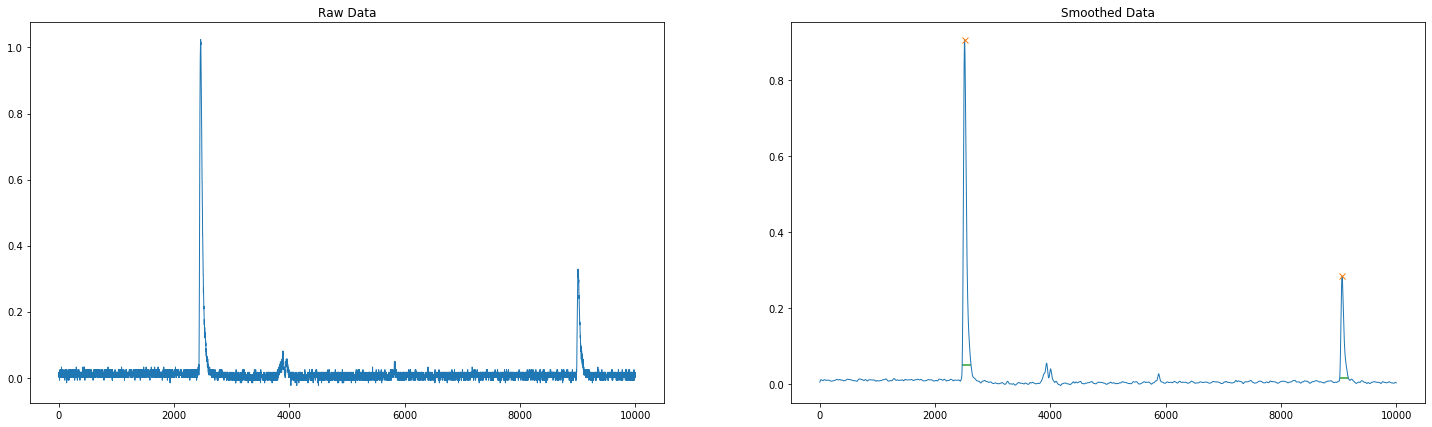

In [11]:
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
plt.plot(data[:,0], data[:,1],'-', lw=1)
plt.plot(peaks, data[:,1][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [12]:
print(f'Peaks width: {results_w[0]}')
for i in range(results_w[1:][0].size):
    print(f'Found peak in range: {results_w[2][i]}, {results_w[3][i]}')
print(f"Found peaks at indices {peaks} with amplitude: {data[peaks,1]}")

Peaks width: [153.61992303 151.85300459]
Found peak in range: 2469.4935010690133, 2623.1134240991305
Found peak in range: 9017.99314862464, 9169.846153211025
Found peaks at indices [2511 9059] with amplitude: [0.90516481 0.28387839]


In [13]:
[int(p) for p in (results_w[2])]

[2469, 9017]

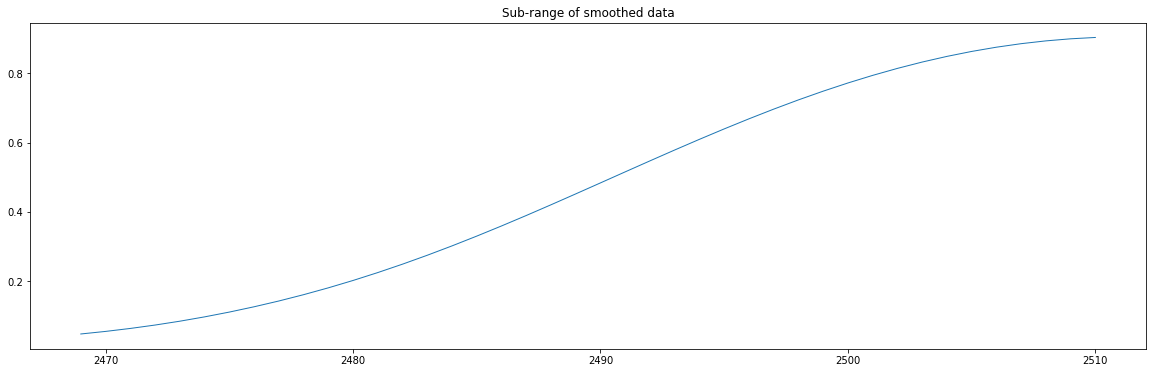

In [14]:
a = int(min(results_w[2]))
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

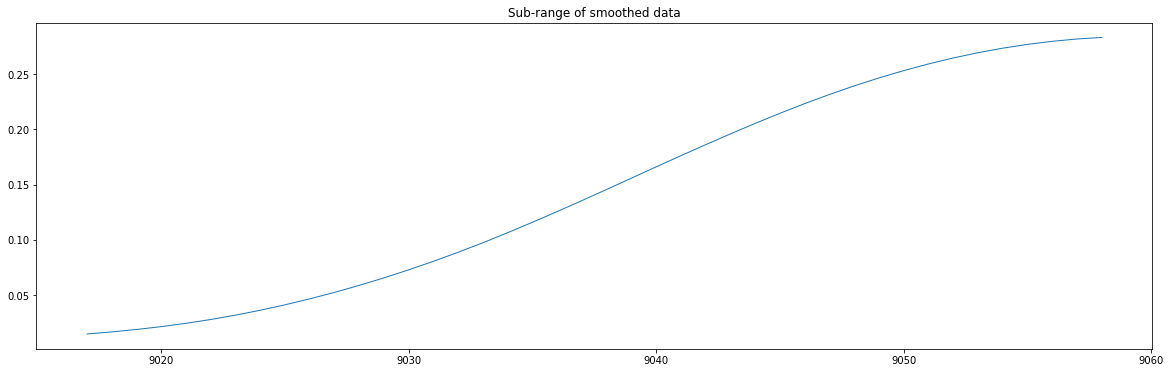

In [15]:
b = int((results_w[2][1]))
# print(b,peaks[1])
ranged_sm_data = data[b:peaks[1]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

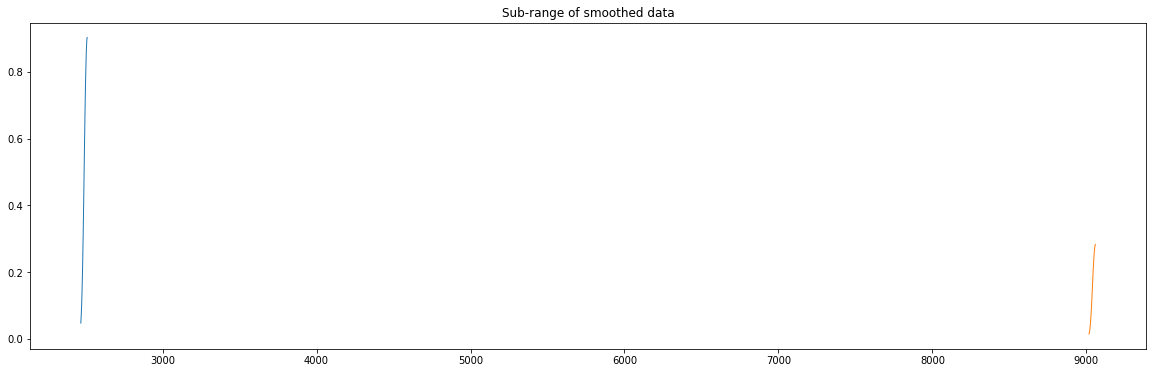

In [16]:
plt.figure(figsize=(20,6))
for min_t, peak in zip(results_w[2], peaks):
    min_t = int(min_t)
    ranged_sm_data = data[min_t:peak]
    plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
    plt.title("Sub-range of smoothed data")
plt.show()

# Fitting 1st peak

In [17]:
# We want to speed things up with Cython
%load_ext Cython

In [18]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3


# def sigmoid(x, p0, p1, p2, p3):
#     return p0 / (1.0 + np.exp(-1.0 * p2 * (x - p1))) + p3


In [19]:
# iminuit.describe(sigmoid)
t1 = np.arange(0, data[a : peaks[0], 0].size)

In [20]:
chi2_fit = probfit.Chi2Regression(
    sigmoid,
    data[a : peaks[0], 0],
#     t1,
    data[a : peaks[0], 1],
)

minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(data[a : peaks[0], 1]),
                p1=np.mean(data[a: peaks[0], 0]),
                p3=np.min(data[a : peaks[0], 1]),
#                 limit_p3=(np.min(data[a : peaks[0], 1]), None),
                pedantic=False,
                print_level=1,
            )
minuit.migrad()
try:
    minuit.hesse()
except Exception as e:
    print(str(e))
# iminuit.describe(chi2_fit)

------------------------------------------------------------------
| FCN = 0.000394                |      Ncalls=97 (97 total)      |
| EDM = 5.2E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

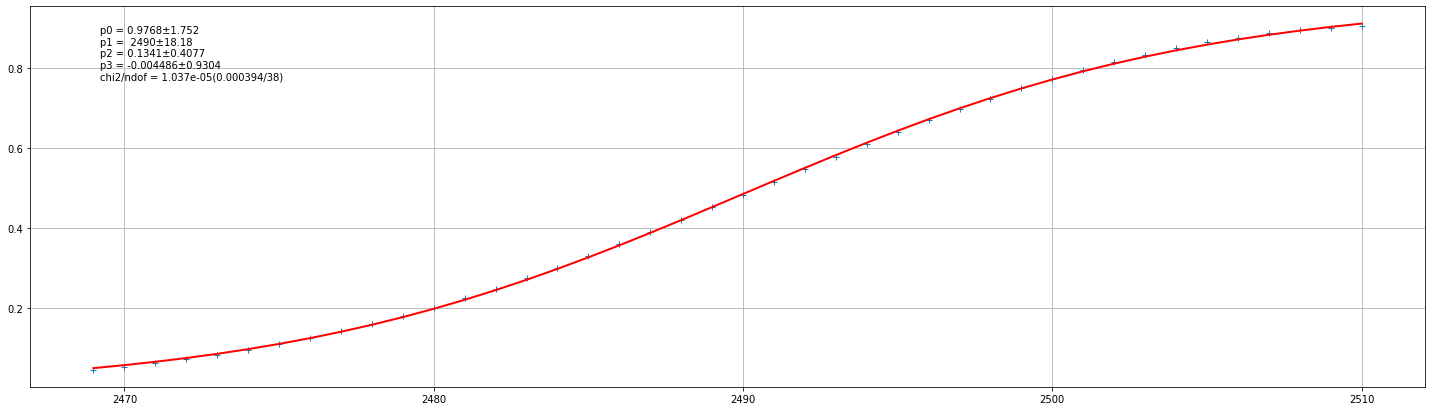

In [21]:
plt.figure(figsize=(25, 7))
chi2_fit.draw(minuit)
plt.show()

In [22]:
p = minuit.values
tz1 = p[1] - np.log(p[0] / (0.2 * data[a : peaks[0] + 1, 1].max() - p[3]) - 1.0) / p[2]
tr1 = tz1 + data[a, 0]
print(tz1, tr1)

2479.14800669997 4948.14800669997


In [23]:
print(minuit.values)
print(minuit.errors)

<ValueView of Minuit at 55a6a2a7fa00>
  p0: 0.9767701875428817
  p1: 2489.962547357029
  p2: 0.13412087978922138
  p3: -0.004486408740954223
<ErrorView of Minuit at 55a6a2a7fa00>
  p0: 1.7519408920243893
  p1: 18.176736981285423
  p2: 0.40772038123661736
  p3: 0.9304273538217378


In [24]:
print(f'The value of the variable p0 is {minuit.values["p0"]}') 
print(f'The value of the variable p1 is {minuit.values["p1"]}') 
print(f'The value of the variable p2 is {minuit.values["p2"]}') 
print(f'The value of the variable p3 is {minuit.values["p3"]}') 

The value of the variable p0 is 0.9767701875428817
The value of the variable p1 is 2489.962547357029
The value of the variable p2 is 0.13412087978922138
The value of the variable p3 is -0.004486408740954223


## Fitting second peak

------------------------------------------------------------------
| FCN = 5.031E-05               |     Ncalls=152 (152 total)     |
| EDM = 1.72E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

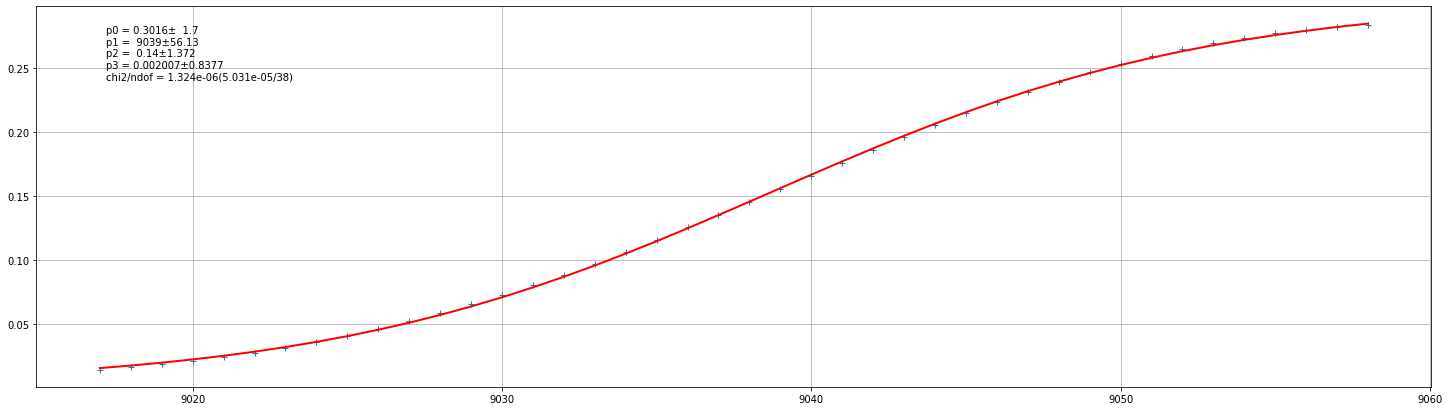

In [25]:
t2 = np.arange(0, data[b : peaks[1], 0].size)
chi2_fit_p2 = probfit.Chi2Regression(
    sigmoid,
    data[b : peaks[1], 0],
#     t2,
    data[b : peaks[1], 1],
)

minuit_p2 = iminuit.Minuit(
                chi2_fit_p2,
#                 p0=np.max(data[b : peaks[1], 1]),
#                 limit_p1=(data[b, 0], np.mean(data[b : peaks[1], 0])),
                p1=np.mean(data[b : peaks[1], 0]),
                p3=np.min(data[b : peaks[1], 1]),
#                 limit_p3=(np.min(data[b : peaks[1], 1]), None),
#                 fix_p3=np.min(data[b : peaks[1], 1]),
                pedantic=False,
                print_level=1,
            )

minuit_p2.migrad()
try:
    minuit_p2.hesse()
except Exception as e:
    print(str(e))

plt.figure(figsize=(25, 7))
chi2_fit_p2.draw(minuit_p2)
plt.show()
# iminuit.describe(sigmoid)

In [26]:
print(f'The value of the variable p0 is {minuit_p2.values["p0"]}') 
print(f'The value of the variable p1 is {minuit_p2.values["p1"]}') 
print(f'The value of the variable p2 is {minuit_p2.values["p2"]}') 
print(f'The value of the variable p3 is {minuit_p2.values["p3"]}') 

The value of the variable p0 is 0.3015925931079998
The value of the variable p1 is 9038.671489321421
The value of the variable p2 is 0.13997629261209532
The value of the variable p3 is 0.0020069292711096124


In [27]:
pp = minuit_p2.values
tz2 = pp[1] - np.log(pp[0] / (0.2 * data[b : peaks[1], 1].max() - pp[3]) - 1) / pp[2]
tr2 = tz2 + data[b, 0]
print(tz2, tr2)

9027.894874092568 18044.89487409257


In [28]:
np.mean(data[a: peaks[0], 0])

2489.5

## Trying ROOT fitting because iminuit doesnt like that data

In [29]:

sg = """
Double_t sig_cpp(Double_t *x, Double_t *par)
{
  return par[0] / (1.0 + TMath::Exp(-par[2] * (x[0] - par[1]))) + par[3];
};
"""
ROOT.gInterpreter.Declare(sg)

True

 FCN=0.000434201 FROM MIGRAD    STATUS=CONVERGED     441 CALLS         442 TOTAL
                     EDM=4.4326e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00064e+00   1.11841e+00   1.05926e-04  -4.30579e-04
   2  p1           2.49047e+03   1.34885e+01   1.97360e-03   3.26094e-06
   3  p2           1.28888e-01   2.31372e-01   2.45399e-05  -8.25948e-05
   4  p3          -1.60502e-02   3.98745e-01   3.54892e-05  -1.48471e-03


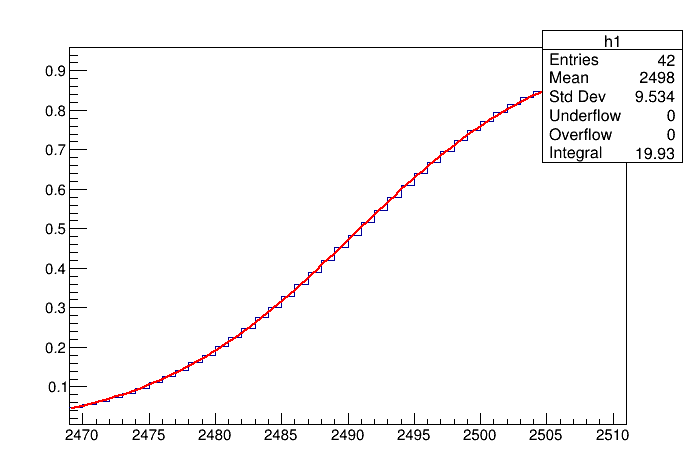

In [30]:
ROOT.gStyle.SetOptStat(1111111)
c1 = TCanvas()
hist_p1 = TH1F("h1"," ", data[a : peaks[0], 0].size, data[a, 0], data[peaks[0], 0])
for i, vt in enumerate(data[a : peaks[0], 1]):
    hist_p1.SetBinContent(hist_p1.GetBin(i + 1), vt)

g1 = TF1("g1", ROOT.sig_cpp, data[a, 0], data[peaks[0], 0], 4)
g1.SetParameter(1, np.mean(data[a: peaks[0], 0]))
hist_p1.Fit(g1, "R")
hist_p1.Draw("same")
c1.Draw()

 FCN=0.000158121 FROM MIGRAD    STATUS=CONVERGED     389 CALLS         390 TOTAL
                     EDM=6.50255e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.10518e-01   5.92858e-01   6.03773e-05  -7.19235e-05
   2  p1           9.03916e+03   2.41314e+01   4.31021e-03  -1.26566e-06
   3  p2           1.33018e-01   4.06241e-01   4.60799e-05  -1.68352e-03
   4  p3          -2.20004e-03   1.92320e-01   1.93487e-05   1.65006e-03


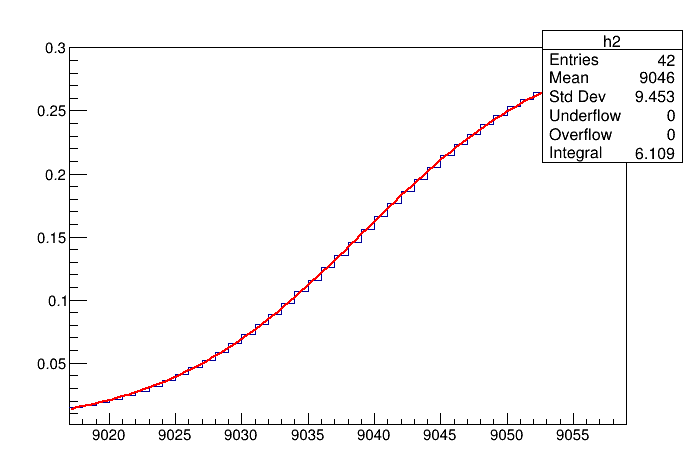

In [31]:
ROOT.gStyle.SetOptStat(1111111)
c1 = TCanvas()
hist_p2 = TH1F("h2"," ", data[b : peaks[1], 0].size, data[b, 0], data[peaks[1], 0])
for i, vt in enumerate(data[b : peaks[1], 1]):
    hist_p2.SetBinContent(hist_p2.GetBin(i + 1), vt)

g2 = TF1("g2", ROOT.sig_cpp, data[b, 0], data[peaks[1], 0], 4)
g2.SetParameter(1, np.mean(data[b: peaks[1], 0]))
hist_p2.Fit(g2, "R")
hist_p2.Draw("same")
c1.Draw()

## whatever stuf

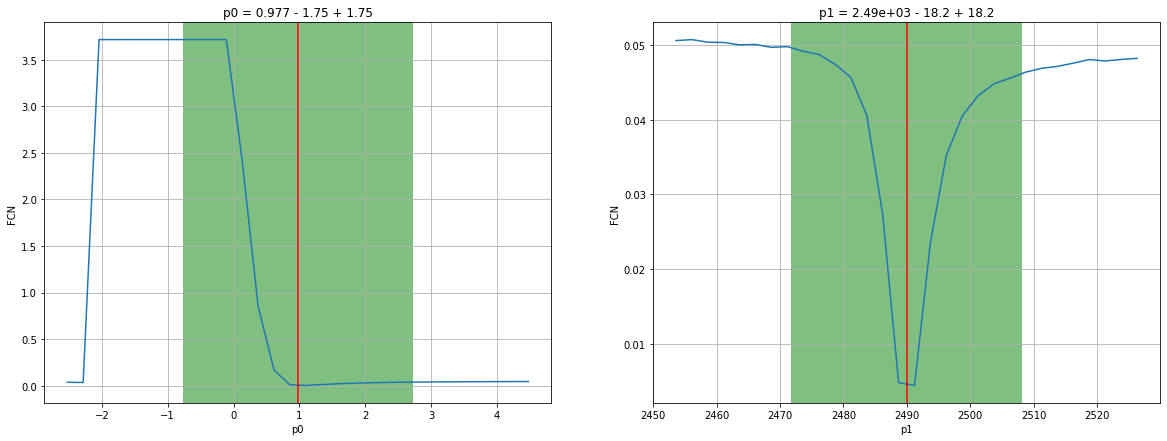

In [32]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p0')
plt.subplot(122)
minuit.draw_mnprofile('p1')
plt.show()

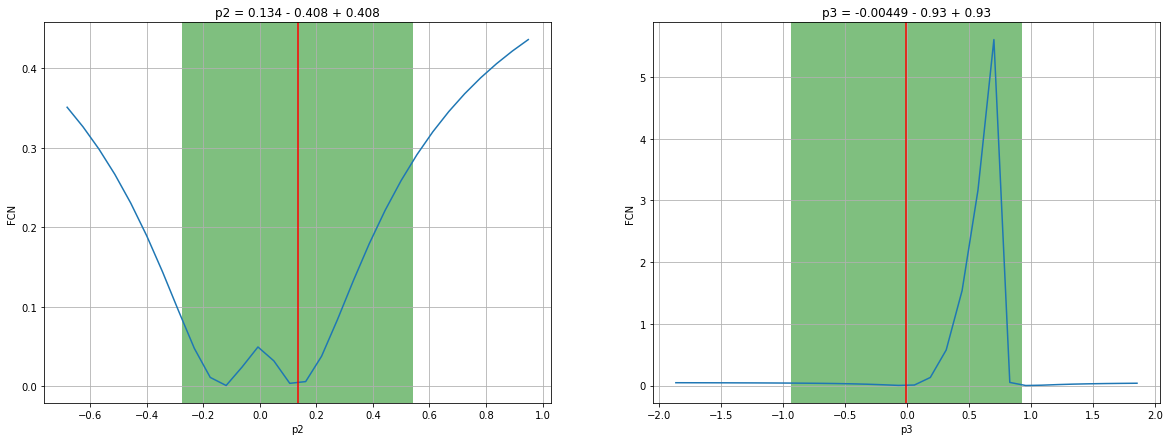

In [33]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p2')
plt.subplot(122)
minuit.draw_mnprofile('p3')
plt.show()

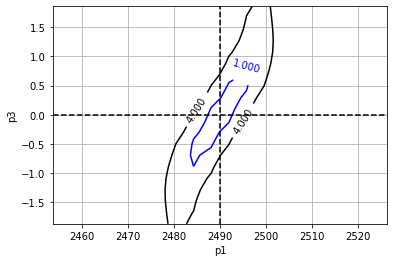

In [45]:
minuit.draw_contour('p1', 'p3')
plt.show()